<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pandas_ta


In [32]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the Stock data only here

In [33]:
# Fetch historical stock data using yfinance
ticker = 'VITL'
start_date , end_date = '2021-01-01' , '2024-03-08'

df = yf.download(ticker, start=start_date, end= end_date)
df['Date'] = df.index
df['Month'] = df.index.month
df['Year'] = df.index.year

# Calculate technical indicators (RSI, MACD, ATR, Bolinger Bands) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.ta.atr(length=14, append=True)
df.ta.bbands(append=True)
# Calculate the 7-day moving average
df['7_day_MA'] = df['Close'].rolling(window=20).mean()

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA
Date,,,,,,,,,,,,,,,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800,2021-01-04,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100,2021-01-05,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200,2021-01-06,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200,2021-01-07,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400,2021-01-08,1,2021,NaN,NaN,NaN,NaN,NaN,24.538943,26.386,28.233057,14.00028,0.709523,NaN


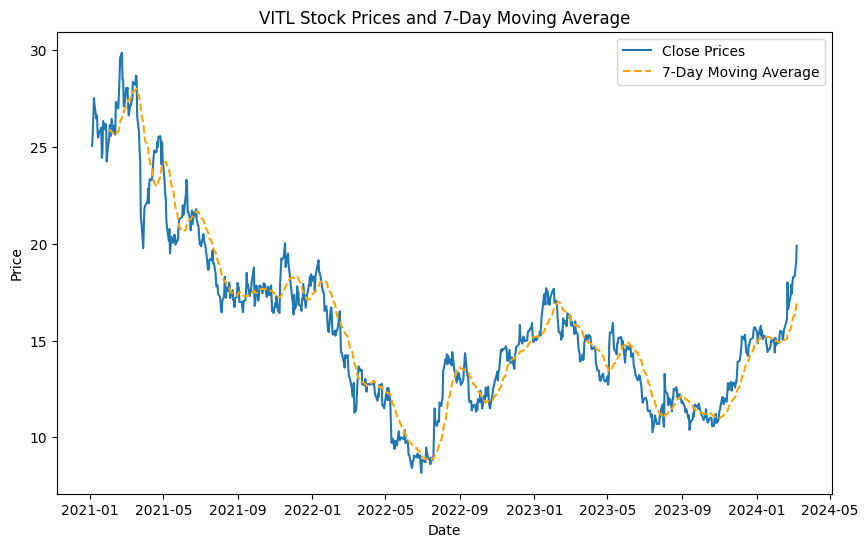

In [34]:
# Plot the closing prices and 7-day moving average
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Prices')
plt.plot(df['7_day_MA'], label='7-Day Moving Average', linestyle='--', color='orange')
plt.title(f'{ticker} Stock Prices and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

##  Add external macro-economic data

[*********************100%%**********************]  1 of 1 completed


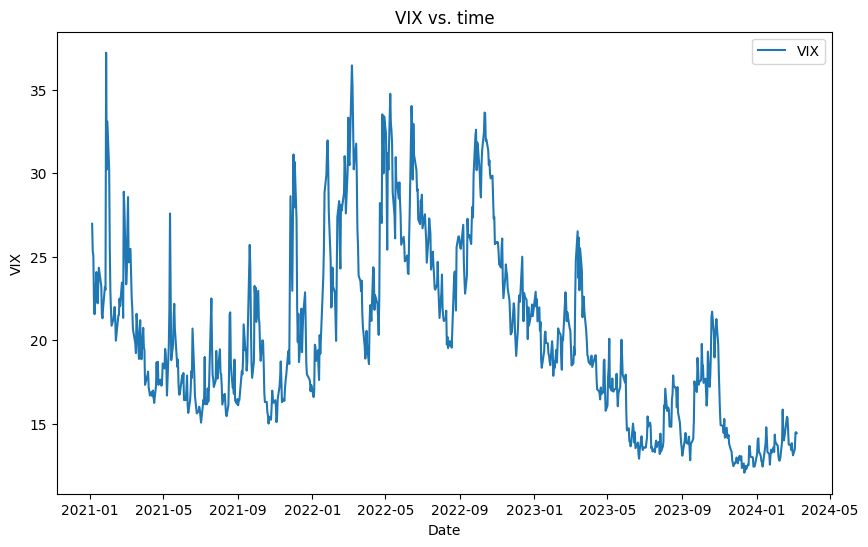

,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,...,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800,2021-01-04,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.969999
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100,2021-01-05,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.340000
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200,2021-01-06,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.070000
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200,2021-01-07,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.370001
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400,2021-01-08,1,2021,NaN,...,NaN,NaN,NaN,24.538943,26.386,28.233057,14.00028,0.709523,NaN,21.559999


In [35]:
# Fetch VIX data from Yahoo Finance using yfinance
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Rename the 'Adj Close' column to 'VIX' for consistency
vix_data = vix_data.rename(columns={'Adj Close': 'VIX'})

# Merge the stock_data DataFrame with the VIX data
df = pd.merge(df, vix_data['VIX'], how='left', left_index=True, right_index=True)
df['Date'] = df.index


# Plot vix data
plt.figure(figsize=(10, 6))
plt.plot(vix_data['VIX'], label='VIX')
plt.title('VIX vs. time')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

df.head()

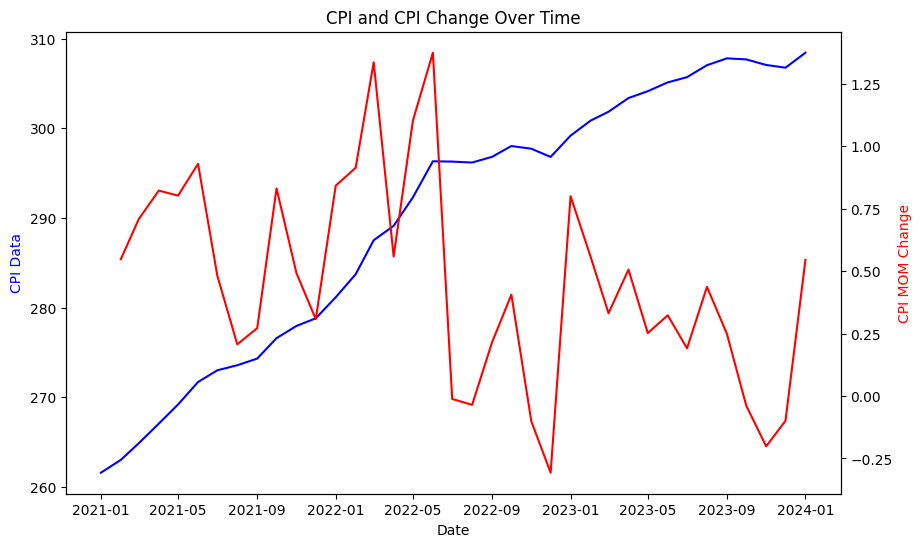

,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,...,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX,CPIAUCNS,CPI_Rolling_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800,2021-01-04,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.969999,261.720581,261.651290
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100,2021-01-05,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.340000,261.766774,261.674387
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200,2021-01-06,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.070000,261.812968,261.697484
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200,2021-01-07,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.370001,261.859161,261.720581
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400,2021-01-08,1,2021,NaN,...,NaN,24.538943,26.386,28.233057,14.00028,0.709523,NaN,21.559999,261.905355,261.743677


In [36]:
# Fetch Consumer Price Index (CPI) data from FRED
cpi_data = web.DataReader("CPIAUCNS", "fred", start_date, end_date)

# Assuming 'cpi_data' is your DataFrame and 'CPIAUCNS' is the column representing CPI
cpi_data['InflationChange'] = cpi_data['CPIAUCNS'].pct_change() * 100
cpi_data['Month'] = cpi_data.index.month
cpi_data['Year'] = cpi_data.index.year

# Plot the  CPI and CPI MOM percent change
fig, ax1 = plt.subplots(figsize= (10,6))

# Plot CPI on primary y-axis
ax1.plot(cpi_data.index, cpi_data['CPIAUCNS'], color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI Data', color='b')

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(cpi_data.index, cpi_data['InflationChange'], color='r')
ax2.set_ylabel('CPI MOM Change', color='r')

plt.title('CPI and CPI Change Over Time')
plt.show()


# Sampling
#cpi_data['date'] = cpi_data.index

# Convert 'Date' column to datetime format
#cpi_data['date'] = pd.to_datetime(cpi_data['date'])

#Resample monthly data to daily frequency and fill missing values with forward fill
#daily_cpi_data = cpi_data.resample('D').ffill()

# Resample monthly data to daily frequency and interpolate missing values
daily_cpi_data = cpi_data[['CPIAUCNS']].resample('D').interpolate(method='linear')

# Calculate rolling average with a window of 30 days
daily_cpi_data['CPI_Rolling_Avg'] = daily_cpi_data['CPIAUCNS'].rolling(window=30, min_periods=1).mean()



#daily_cpi_data.head()

# Merge the stock_data DataFrame with the VIX data
df = pd.merge(df, daily_cpi_data[['CPIAUCNS','CPI_Rolling_Avg' ]], how='left', left_index=True, right_index=True)
df['Date'] = df.index

df.head()

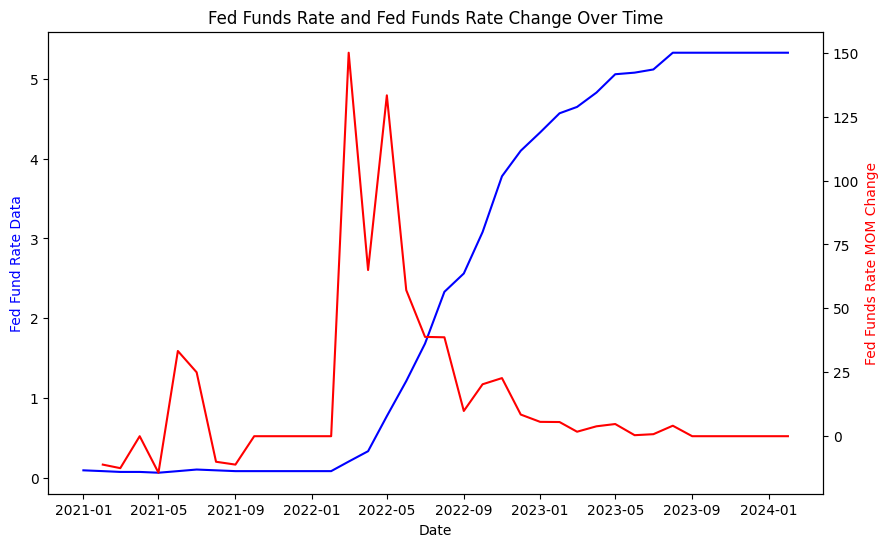

,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,...,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX,CPIAUCNS,CPI_Rolling_Avg,FEDFUNDS,FEDFUNDS_Rolling_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800,2021-01-04,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,26.969999,261.720581,261.651290,0.089032,0.089516
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100,2021-01-05,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,25.340000,261.766774,261.674387,0.088710,0.089355
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200,2021-01-06,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,25.070000,261.812968,261.697484,0.088387,0.089194
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200,2021-01-07,1,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,22.370001,261.859161,261.720581,0.088065,0.089032
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400,2021-01-08,1,2021,NaN,...,26.386,28.233057,14.00028,0.709523,NaN,21.559999,261.905355,261.743677,0.087742,0.088871


In [37]:
# Fetch Federal Funds Rate data from FRED
fed_funds_rate = web.DataReader("FEDFUNDS", "fred", start_date, end_date)

fed_funds_rate['fedfundsChange'] = fed_funds_rate['FEDFUNDS'].pct_change() * 100
fed_funds_rate['Month'] = fed_funds_rate.index.month
fed_funds_rate['Year'] = fed_funds_rate.index.year

# Plot the  Federal Funds Rate and Federal Funds Rate MOM percent change
fig, ax1 = plt.subplots(figsize= (10,6))

# Plot CPI on primary y-axis
ax1.plot(fed_funds_rate.index, fed_funds_rate['FEDFUNDS'], color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fed Fund Rate Data', color='b')

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(fed_funds_rate.index, fed_funds_rate['fedfundsChange'], color='r')
ax2.set_ylabel('Fed Funds Rate MOM Change', color='r')

plt.title('Fed Funds Rate and Fed Funds Rate Change Over Time')
plt.show()

# Resample monthly data to daily frequency and interpolate missing values
daily_fed_funds_rate = fed_funds_rate[['FEDFUNDS']].resample('D').interpolate(method='linear')

# Calculate rolling average with a window of 30 days
daily_fed_funds_rate['FEDFUNDS_Rolling_Avg'] = daily_fed_funds_rate['FEDFUNDS'].rolling(window=30, min_periods=1).mean()

# Merge the stock_data DataFrame with the FED FUNDS RATE
df = pd.merge(df, daily_fed_funds_rate[['FEDFUNDS','FEDFUNDS_Rolling_Avg' ]], how='left', left_index=True, right_index=True)
df['Date'] = df.index

df.head()

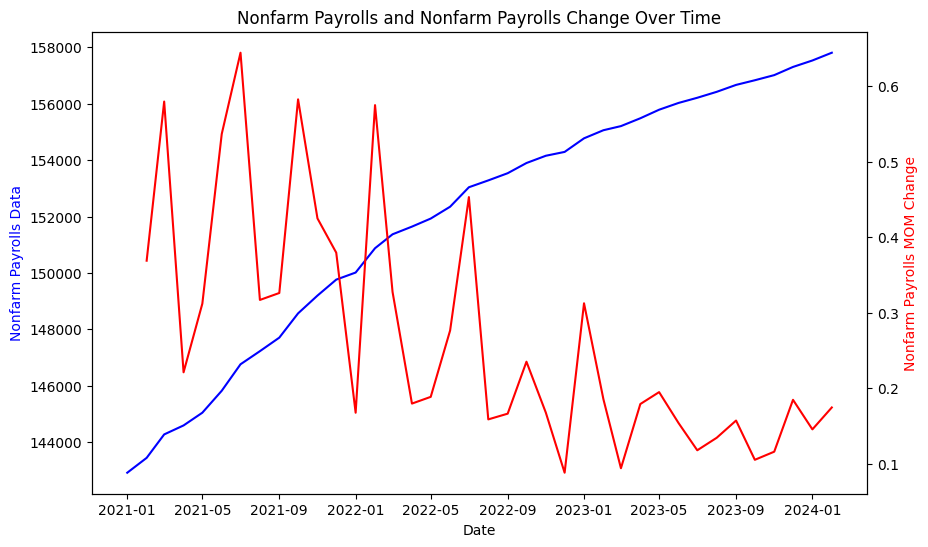

,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,...,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX,CPIAUCNS,CPI_Rolling_Avg,FEDFUNDS,FEDFUNDS_Rolling_Avg,NonfarmPayrolls,NonfarmPayrolls_Rolling_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800,2021-01-04,1,2021,NaN,...,NaN,NaN,NaN,26.969999,261.720581,261.651290,0.089032,0.089516,142967.0,142941.5
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100,2021-01-05,1,2021,NaN,...,NaN,NaN,NaN,25.340000,261.766774,261.674387,0.088710,0.089355,142984.0,142950.0
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200,2021-01-06,1,2021,NaN,...,NaN,NaN,NaN,25.070000,261.812968,261.697484,0.088387,0.089194,143001.0,142958.5
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200,2021-01-07,1,2021,NaN,...,NaN,NaN,NaN,22.370001,261.859161,261.720581,0.088065,0.089032,143018.0,142967.0
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400,2021-01-08,1,2021,NaN,...,14.00028,0.709523,NaN,21.559999,261.905355,261.743677,0.087742,0.088871,143035.0,142975.5


In [38]:
# Fetch Nonfarm Payrolls data from FRED using pandas_datareader
nfp_data = web.DataReader("PAYEMS", "fred", start_date, end_date)
# Rename the column to 'Nonfarm Payrolls' for consistency
nfp_data = nfp_data.rename(columns={'PAYEMS': 'NonfarmPayrolls'})

nfp_data['NonfarmPayrollsChange'] = nfp_data['NonfarmPayrolls'].pct_change() * 100

nfp_data['Month'] = nfp_data.index.month
nfp_data['Year'] = nfp_data.index.year



# Plot the Nonfarm Payrolls and Nonfarm Payrolls MOM percent change
fig, ax1 = plt.subplots(figsize= (10,6))

# Plot CPI on primary y-axis
ax1.plot(nfp_data.index, nfp_data['NonfarmPayrolls'], color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nonfarm Payrolls Data', color='b')

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(nfp_data.index, nfp_data['NonfarmPayrollsChange'], color='r')
ax2.set_ylabel('Nonfarm Payrolls MOM Change', color='r')

plt.title('Nonfarm Payrolls and Nonfarm Payrolls Change Over Time')
plt.show()


# Resample monthly data to daily frequency and interpolate missing values
daily_nfp_data = nfp_data[['NonfarmPayrolls']].resample('D').interpolate(method='linear')

# Calculate rolling average with a window of 30 days
daily_nfp_data['NonfarmPayrolls_Rolling_Avg'] = daily_nfp_data['NonfarmPayrolls'].rolling(window=30, min_periods=1).mean()

# Merge the stock_data DataFrame with the FED FUNDS RATE
df = pd.merge(df, daily_nfp_data[['NonfarmPayrolls','NonfarmPayrolls_Rolling_Avg' ]], how='left', left_index=True, right_index=True)
df['Date'] = df.index

df.head()

In [39]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 7

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,...,BBB_5_2.0,BBP_5_2.0,7_day_MA,VIX,CPIAUCNS,CPI_Rolling_Avg,FEDFUNDS,FEDFUNDS_Rolling_Avg,NonfarmPayrolls,NonfarmPayrolls_Rolling_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,25.410000,25.440001,24.080000,25.059999,25.059999,384800,2021-01-04,1,2021,NaN,...,NaN,NaN,NaN,26.969999,261.720581,261.651290,0.089032,0.089516,142967.0,142941.5
2021-01-05,25.290001,25.820000,25.000999,25.629999,25.629999,317100,2021-01-05,1,2021,NaN,...,NaN,NaN,NaN,25.340000,261.766774,261.674387,0.088710,0.089355,142984.0,142950.0
2021-01-06,26.000000,27.469999,25.500000,26.549999,26.549999,621200,2021-01-06,1,2021,NaN,...,NaN,NaN,NaN,25.070000,261.812968,261.697484,0.088387,0.089194,143001.0,142958.5
2021-01-07,26.139999,27.650000,25.709999,27.530001,27.530001,365200,2021-01-07,1,2021,NaN,...,NaN,NaN,NaN,22.370001,261.859161,261.720581,0.088065,0.089032,143018.0,142967.0
2021-01-08,27.520000,28.500000,26.799999,27.160000,27.160000,459400,2021-01-08,1,2021,NaN,...,14.00028,0.709523,NaN,21.559999,261.905355,261.743677,0.087742,0.088871,143035.0,142975.5


In [40]:
# Columns on the dataframe
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date', 'Month',
       'Year', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'ATRr_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0',
       'BBP_5_2.0', '7_day_MA', 'VIX', 'CPIAUCNS', 'CPI_Rolling_Avg',
       'FEDFUNDS', 'FEDFUNDS_Rolling_Avg', 'NonfarmPayrolls',
       'NonfarmPayrolls_Rolling_Avg'],
      dtype='object')

In [41]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
#features = ['Close', 'Volume']
#features = ['Close', 'Volume','RSI_14','ATRr_14','VIX']
#features = ['Close', 'Volume','RSI_14','MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14','VIX' ]
#features = ['Close', 'Volume','VIX', 'ATRr_14']
features = ['Close', 'Volume', 'RSI_14', 'ATRr_14', 'VIX']
#features = ['Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14', 'VIX', 'FEDFUNDS', 'CPIAUCNS']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')

# Columns to be scaled (excluding Federal Funds Rate)
#columns_to_scale = ['Open', 'Volume', 'RSI_14', 'VIX']

train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,Close,Volume,RSI_14,ATRr_14,VIX
Date,,,,,
2021-01-25,25.910000,684300,52.711197,1.512181,23.190001
2021-01-26,26.200001,730700,54.991633,1.481077,23.020000
2021-01-27,26.139999,926400,54.407030,1.465024,37.209999
2021-01-28,24.250000,637700,39.986946,1.565239,30.209999
2021-01-29,24.730000,641500,44.043238,1.496848,33.090000


### Feature Scaling

In [42]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 778



array([[0.81751148, 0.23120987, 0.54067171, 0.85893502, 0.44232304],
       [0.83087558, 0.24813923, 0.57843295, 0.83549232, 0.4355609 ],
       [0.82811054, 0.31954174, 0.56875264, 0.82339359, 1.        ],
       [0.7410138 , 0.21420753, 0.3299736 , 0.8989239 , 0.72155926],
       [0.76313359, 0.21559399, 0.39714085, 0.84737894, 0.83611778]])

### Creating a data structure with 180 timesteps and 1 output

In [43]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [44]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [45]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (718, 60, 5)


## Part 2 - Building and Training the LSTM

### Initialising the RNN

In [46]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [47]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [48]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [49]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [50]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [51]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [52]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [53]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
23/23 [==============================] - 21s 240ms/step - loss: 0.0279
Epoch 2/100
23/23 [==============================] - 6s 257ms/step - loss: 0.0066
Epoch 3/100
23/23 [==============================] - 2s 97ms/step - loss: 0.0051
Epoch 4/100
23/23 [==============================] - 2s 97ms/step - loss: 0.0039
Epoch 5/100
23/23 [==============================] - 2s 96ms/step - loss: 0.0040
Epoch 6/100
23/23 [==============================] - 3s 121ms/step - loss: 0.0040
Epoch 7/100
23/23 [==============================] - 3s 112ms/step - loss: 0.0032
Epoch 8/100
23/23 [==============================] - 2s 97ms/step - loss: 0.0032
Epoch 9/100
23/23 [==============================] - 2s 97ms/step - loss: 0.0035
Epoch 10/100
23/23 [==============================] - 2s 96ms/step - loss: 0.0030
Epoch 11/100
23/23 [==============================] - 3s 111ms/step - loss: 0.0032
Epoch 12/100
23/23 [==============================] - 3s 122ms/step - loss: 0.0032
Epoch 13/100
23/23

## Part 3 - Making the predictions and visualising the results

In [54]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,Close,Volume,RSI_14,ATRr_14,VIX
Date,,,,,
2024-02-28,17.430000,230900,62.983078,0.651171,13.84
2024-02-29,17.969999,333700,66.155018,0.648230,13.40
2024-03-01,18.260000,397600,67.753116,0.643714,13.11
2024-03-04,18.330000,249300,68.144119,0.624877,13.49
2024-03-05,18.730000,410100,70.356074,0.630957,14.46


In [55]:
# Plot a line chart using Plotly Express
#fig = px.line(dataset_test, x=dataset_test.index, y='7_day_MA', title='7-Day Moving Average Stock Price Over Time')
fig = px.line(dataset_test, x=dataset_test.index, y='Close', title='Stock Price Over Time')
# Show the plot
fig.show()

In [56]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[17.43000031],
       [17.96999931],
       [18.26000023],
       [18.32999992],
       [18.72999954]])

In [57]:
len(dataset_test)

7

### Getting the predicted stock price

In [58]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag : ].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (67, 5)

Shape of inputs after reshaping: (67, 5)
Shape of X_test before reshaping: (7, 60, 5)

Shape of X_test after reshaping: (7, 60, 5)
1/1 [==============================] - 2s 2s/step


### Visualising the results

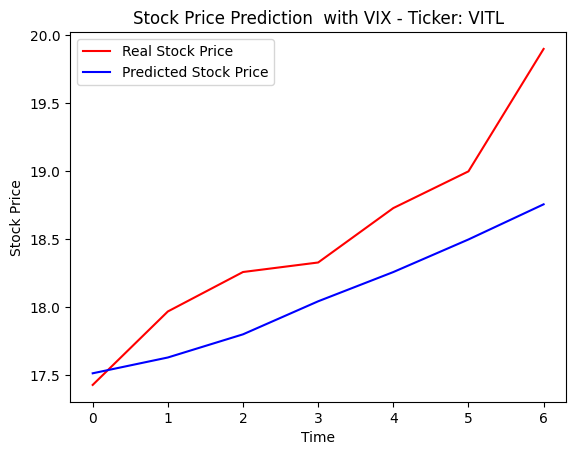

In [59]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title(f'Stock Price Prediction  with VIX - Ticker: {ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Monte- Carlo Simulation

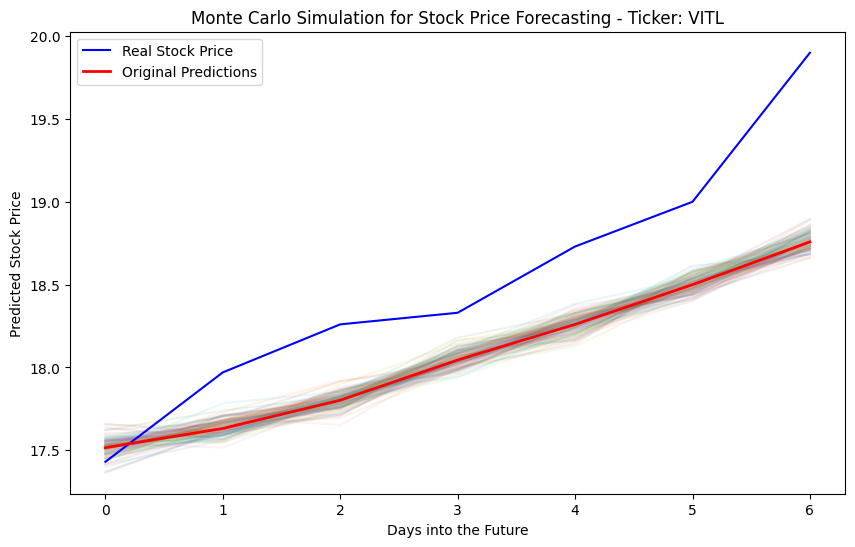

In [60]:
# Generate dummy features for the next few day

# Number of simulations for the Monte Carlo simulation
num_simulations = 100

# Create an array to store simulation results
simulation_results = np.zeros((num_simulations, len(model_predictions)))

# Perform Monte Carlo simulation
for i in range(num_simulations):
    # Introduce random noise to the model predictions
    noise = np.random.normal(0, 0.05, len(model_predictions))  # Adjust the standard deviation as needed
    simulated_predictions = model_predictions + noise

    # Store the simulated predictions in the results array
    simulation_results[i, :] = simulated_predictions

# Plot the Monte Carlo simulation results

plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(np.arange(len(model_predictions)), simulation_results[i, :], linestyle='-', marker='', alpha=0.1)

# Plot the original predictions
plt.plot(real_stock_price, color = 'blue', label = 'Real Stock Price')
plt.plot(np.arange(len(model_predictions)), model_predictions, label='Original Predictions', color='red', linewidth=2)

plt.title(f'Monte Carlo Simulation for Stock Price Forecasting - Ticker: {ticker}')
plt.xlabel('Days into the Future')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.show()
